# 卷积神经网络-第二周
卷积神经网络 (Convolutional Neural Networks) 是一种深度学习模型，常用来分析视觉图像。著名计算机科学家 Yann LeCun 是第一个通过卷积神经网络在MNIST数据集上解决手写数字识别问题的人。在第二周的实验中，你将学习使用pytorch框架搭建一个完整的卷积神经网络，训练其进行手写数字识别任务。
你将学习到：
- 如何从头开始搭建完整的计算机视觉任务pipeline
- （可选的）对卷积神经网络提取到的特征进行可视化

## 1. 池化

在上周的实验中，我们对卷积运算的一些重要性质进行了研究，并直观地了解了将卷积运算用于计算机视觉任务背后的动机。

（1）尽管卷积运算天然的具有对平移操作的等变性，但是对其他变化（例如：图像缩放、旋转）并不具有天然的等变性；

（2）对于平移操作，我们不仅仅期望模型具有等变性，还希望模型具有**局部平移不变性**。例如：当判断一张图像中是否包含人脸时，我们不需要知道眼睛的精确像素位置，只需要知道有一只眼睛在脸的左边，另一只在右边就可以了。

接下来，我们将借助另一种运算：池化，来进一步改进计算机视觉模型。

和之前一样，我们从加载一张图像，并以其中一个通道为例进行实验：

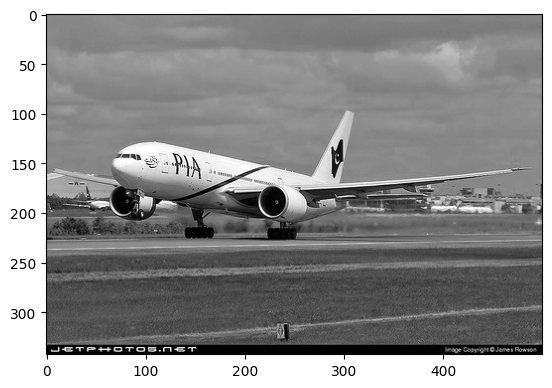

In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

img = Image.open('src\plane2.jpg')
r, g, b = img.split()
data = np.array(r)
n,m = data.shape
plt.figure()
plt.imshow(r, cmap='gray')

同样地，使用卷积操作进行特征提取：

(-0.5, 496.5, 339.5, -0.5)

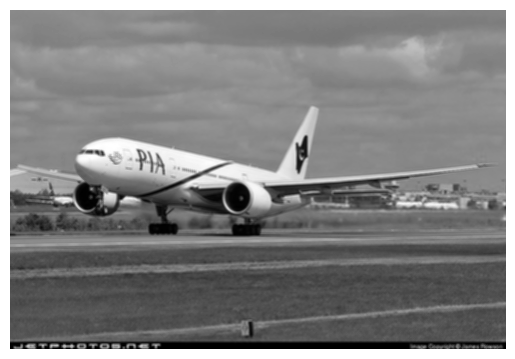

In [2]:
kernel = np.array([
    [1,1,1],
    [1,2,1],
    [1,1,1]
])

def convolution(k, data):
    n,m = data.shape
    img_new = []
    for i in range(n-3):
        line = []
        for j in range(m-3):
            a = data[i:i+3,j:j+3]
            line.append(np.sum(np.multiply(k, a)))
        img_new.append(line)
    return np.array(img_new)

img_new = convolution(kernel, data)
plt.imshow(img_new, cmap='gray')
plt.axis('off')

以最大值池化（Max pooling）为例，最大值池化函数的示意图如下：

<img src="src/max_pool.png" style="width:400px;height:400;">

**1. 定义**

最大值池化是一种下采样（downsampling）技术，它通过在输入特征图的局部区域内取最大值来减少空间分辨率。池化操作通常在卷积层之后应用，目的是：

- 提取最重要的特征。
- 减少计算量和参数数量。
- 增强模型对平移、旋转等变换的鲁棒性。

**2. 原理**

最大值池化通过一个固定大小的窗口（通常称为池化核或池化窗口）在输入特征图上滑动，在每个窗口内选择最大值作为输出。输出特征图的尺寸通常比输入小，具体取决于池化核的大小和步幅（stride）。

操作步骤：
- 定义池化核大小（例如 2×2 ）。
- 定义步幅（stride=2），即窗口滑动的距离。
- 在输入特征图上滑动池化核，计算每个窗口内的最大值。
- 将这些最大值组成新的特征图。

输入是一张图像，最大值池化操作的做法是：以特定的步长（stride=2）遍历整张图像，每一步中对原始图像的局部取最大值记在输出特征映射的对应位置。

### **实验问题1**：手动设计最大池化函数

**要求**：
- 输入：单通道图像I，池化操作的步长stride
- 输出：池化后的特征映射

In [13]:
def pooling(I, stride):
    (W, H) = I.shape
    ### YOUR CODE BEGIN
    ###  result = I[::10,::10]
    ### YOUR CODE END
    
    
    return result

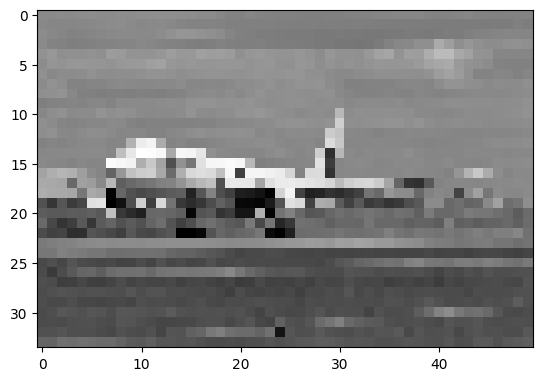

In [14]:
result = pooling(img_new,5)
plt.imshow(result, cmap='gray')

## 2. 组建卷积神经网络

<img src="src/arch.png" style="width:400px;height:400;">

上图展示了一个经典卷积神经网络的组件，包括卷积层-池化层-全连接层构成。其中，卷积层由若干可学习的卷积核组成，使用梯度反向传播的方式自动学习最优的卷积核（而不是手动设计）。池化层一般使用均值池化和最大值池化来实现，不包含可学习参数，最后跟着一层（或几层）全连接神经网络映射到目标空间。

下图展示了Yann LeCun所实现的卷积神经网络，包含卷积-池化-卷积-池化-全连接五层结构，也被称为LeNet5。

<img src="src/lenet.webp" style="width:800px;height:600;">

接下来，我们将使用pytorch框架复现LeNet5。

PyTorch 是一个非常流行的选择，它提供了许多有用的工具和函数来帮助开发者创建高效的深度学习模型。遇到问题时，你可以参考官方文档：https://pytorch.org

In [3]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision
import torch.nn.functional as F

- Transform 可以在模型训练前或推理时自动地对数据进行处理。PyTorch 提供了许多内置的 Transform 函数，如 Resize、Normalize、ToTensor 等，也支持自定义来适应特定的数据处理需求。

In [4]:
data_tf = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize([0.5], [0.5]),
     transforms.Resize([32,32])])

- Dataset 是一个抽象类，用于表示数据集。你可以自定义 Dataset 来处理任何类型的数据集，包括图片、音频、文本等等。在自定义 Dataset 中，你需要实现 __getitem__ 函数来获取单个数据样本以及它的标签，还需要实现 __len__ 函数来获取数据集的大小。

- DataLoader 是一个可迭代对象，它将 Dataset 中的数据分批次加载到模型中。在实例化 DataLoader 时，你可以指定每个批次的大小、是否打乱数据、以及使用多线程来预处理数据等参数。在模型训练过程中，你可以直接通过迭代 DataLoader 来获取每个批次的数据和标签。

In [5]:
# 超参数
EPOCH = 1           # 训练整批数据多少次, 为了节约时间, 我们只训练一次
BATCH_SIZE = 32
LR = 0.001          # 学习率
DOWNLOAD_MNIST = True  # 如果你已经下载好了mnist数据就写上 False

In [6]:
# 读取测试数据，train=True读取训练数据；train=False读取测试数据
train_dataset = datasets.MNIST(root='./data', train=True, transform=data_tf, download=DOWNLOAD_MNIST)
test_dataset = datasets.MNIST(root='./data', train=False, transform=data_tf)

### 这两行代码从原始数据中选择一个小的子集，在debug时可以减少计算量
#train_dataset = torch.utils.data.Subset(train_dataset, range(100))
#test_dataset = torch.utils.data.Subset(test_dataset, range(100))

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:02<00:00, 4620870.20it/s]


Extracting ./data\MNIST\raw\train-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 177290.77it/s]


Extracting ./data\MNIST\raw\train-labels-idx1-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1616810.27it/s]


Extracting ./data\MNIST\raw\t10k-images-idx3-ubyte.gz to ./data\MNIST\raw

Failed to download (trying next):
HTTP Error 502: Bad Gateway



100%|██████████| 4542/4542 [00:00<00:00, 2175214.52it/s]

Extracting ./data\MNIST\raw\t10k-labels-idx1-ubyte.gz to ./data\MNIST\raw



### **实验问题2**：从数据集中读取样本并可视化

**要求**：补全代码，可视化test_loader中前3张图像

tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1])
torch.Size([32, 1, 32, 32])


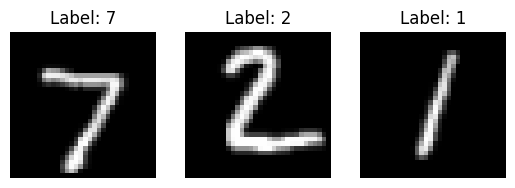

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()

examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(example_targets)
print(example_data.shape)
for i in range(3):
### YOUR CODE BEGIN
### YOUR CODE END

plt.show()

In [8]:
# 批训练 32samples, 1 channel, 28x28 (32, 1, 28, 28)
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

接下来，我们需要使用pytorch定义一个卷积神经网络。具体地，你需要创建一个继承自 nn.Module 的类，该类至少包含一个 forward 函数和一些卷积层、池化层和全连接层等模型组件。

### **实验问题3**：动手实现lenet-5。

**要求**：

- 卷积层 1：输入通道数 1，输出通道数 6，卷积核大小 5x5，步长为 1，填充为 0。

- 池化层 1：池化核大小为 2x2，步长为 2。

- 卷积层 2：输入通道数 6，输出通道数 16，卷积核大小 5x5，步长为 1，填充为 0。

- 池化层 2：池化核大小为 2x2，步长为 2。

- 全连接层 1：输入特征数为 16x5x5，输出特征数为 120。

- 全连接层 2：输入特征数为 120，输出特征数为 84。

- 输出层：输入特征数为 84，输出特征数为分类数目。

In [ ]:
class LeNet(nn.Module):
    def __init__(self, num_classes=10):
        super(LeNet, self).__init__()
        
        # 定义 LeNet-5 的卷积层和池化层
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        ### YOUR CODE BEGIN
        
        ### YOUR CODE END
        
        # 定义 LeNet-5 的全连接层
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        
        # 定义激活函数
        self.tanh = nn.Tanh()
        
    def forward(self, x):
        ### YOUR CODE BEGIN
        # 输入 x 的尺寸：(batch_size, 1, 32, 32)
        # 卷积层 1，输出尺寸：(batch_size, 6, 28, 28)

        # 池化层 1，输出尺寸：(batch_size, 6, 14, 14)

        
        # 卷积层 2，输出尺寸：(batch_size, 16, 10, 10)

        # 池化层 2，输出尺寸：(batch_size, 16, 5, 5)

        
        # 将特征图展开成一维向量
        x = x.view(-1, 16*5*5)  # (batch_size, 16*5*5)
        
        # 全连接层 1，输出尺寸：(batch_size, 120)

        
        # 全连接层 2，输出尺寸：(batch_size, 84)

        
        # 输出层，输出尺寸：(batch_size, num_classes)

        ### YOUR CODE END
        
        return x

定义好之后，你可以打印网络的结构来验证是否符合预期：

In [10]:
net = LeNet()
print(net)

LeNet(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (tanh): Tanh()
)


在训练 CNN 时，还需要定义一个损失函数和优化器。

In [11]:
optimizer = torch.optim.Adam(net.parameters(), lr=LR)   # optimize all cnn parameters
loss_func = nn.CrossEntropyLoss()   # the target label is not one-hotted

接下来开始训练过程；

### **实验问题4**：搭建训练和测试框架

**要求**：参考注释进行补全，如果已实现的代码框架不符合你的品味，你可以对整体进行大的改动

In [ ]:
from tqdm import tqdm

for epoch in range(EPOCH):
    # training
    for (b_x, b_y) in tqdm(train_loader, total=len(train_loader)):   # 取出一个batch的数据，tqdm可以制作进度条
        output = net(b_x)               # 正向传播，这一行会自动调用net类的forward方法
        loss = loss_func(output, b_y)   # 计算cross entropy loss
        optimizer.zero_grad()           # 清空之前计算的梯度
        loss.backward()                 # 反向传播，计算新的梯度
        optimizer.step()                # 根据梯度调用优化器对参数进行调整
    # testing
    net.eval()
    losses, preds, tgts = [], [], []
    for (b_x, b_y) in tqdm(train_loader, total=len(train_loader)):   # 取出一个batch的数据，tqdm可以制作进度条
        output = net(b_x)               # 正向传播，这一行会自动调用net类的forward方法
        ### YOUR CODE BEGIN
        ### pred：Batch_size * 1的numpy矩阵，每个样本的预测标签
        ### loss: Batch_size * 1的numpy矩阵，每个样本的损失
        pred = # 获取预测类别
        loss = # 计算损失
        
        ### YOUR CODE END
        losses.append(loss)
        preds.append(pred)
        tgt = b_y.cpu().detach().numpy()
        tgts.append(tgt)
        
    metrics = {"loss": np.mean(losses)}
    tgts = [l for sl in tgts for l in sl]
    preds = [l for sl in preds for l in sl]
    ### YOUR CODE BEGIN
    ### 根据tgts和preds计算acc，并存入metrics["acc"]中
    ### YOUR CODE END
    
    print("Epoch:{}, Loss: {:.5f} , acc: {:.5f}".format(epoch, metrics["loss"], metrics["acc"]))            

100%|██████████| 1875/1875 [00:18<00:00, 102.11it/s]


Epoch:0, Loss: 0.06628 , acc: 0.97992


在无GPU的情况下，完整训练一次是相对而言比较耗时的（约10min），因此需要将学习到的模型参数从显存（GPU）或者内存（CPU）中固化到磁盘上，我们需要借助torch.save和torch.load方法来实现这一需求：

In [13]:
### 保存模型参数
torch.save(net,'save/lenet.pt')

### 加载模型参数
net = torch.load('save/lenet.pt')

### torch.save和torch.load保存的内容是网络的结构及所有可学习参数的值，是相对而言更简便的用法；
### 在某些情况下你可能还需要使用torch.save(model.state_dict(), 'save.pt')只保存参数而不保存模型结构

尝试加载一张自己的手写数字图像进行测试：

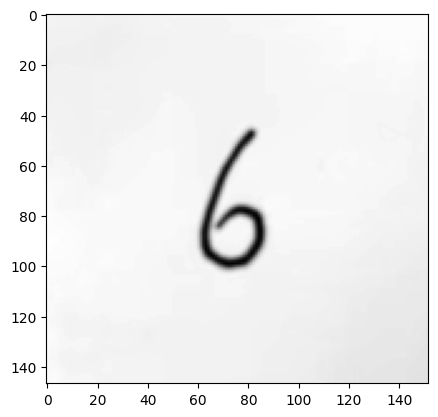

In [14]:
img = Image.open('src/6.png').convert('L')
plt.figure()
plt.imshow(img, cmap='gray')

In [15]:
test_sample = data_tf(img)
test_sample = test_sample.reshape(1,1,32,32)
print(test_sample.shape)

torch.Size([1, 1, 32, 32])


In [ ]:
output = net(test_sample)
pred = output.argmax(dim=1).cpu().detach().numpy()
print("预测结果：{}".format(pred))#有可能识别错误，但是无妨，可以成其他数字图片尝试一下

预测结果：[8]


## 3. （可选）特征可视化

在上文中，我们实现了一个简单的pipeline来借助卷积神经网络实现手写数字识别。卷积神经网络能够以可学习的方式对卷积核的参数进行优化，寻找到最优的特征提取方式，在下文中，我们将学习使用一些先进的工具对卷积神经网络所提取到的特征进行可视化，进而更直观的感受CNN到底依靠什么作为分类证据。

下图展示了一些基于类激活映射（CAM: Class Activation Map）\[1\]实现的特征可视化结果：

<img src="src/cam-examples.png" style="width:600px;height:400;">

这一方法可以对基于CNN的分类网络学习到的特征进行可视化。

CAM的原理可以概括为：在卷积神经网络中，最后一层卷积层输出的特征映射（C\*W\*H的张量）分别对应着输入图像中的C个抽象特征。经过卷积-非线性特征映射-池化等一系列操作，这些特征对人而言可能是高度抽象的，无法直接理解。但是，（1）全连接层学习到的权重一定程度上代表了这些特征对于最终分类的重要性；（2）由于卷积操作和池化操作的性质，特征映射和原始图像在空间位置上是存在对应关系的；因此，我们可以将最后全连接层学习到的权重系数与特征映射的每个通道相乘并进行叠加，得到最终的热力图用于可视化，热力图值较高的区域表示模型重点关注的区域。

如下图所示：

<img src="src/cam.png" style="width:800px;height:400;">

其中，GAP表示全局平均池化（Globle Average Pooling），需要注意的是，这种特征可视化方式对模型结构有一些限制：要求模型必须使用GAP的池化方式，并且池化之后只能有一层全连接层。

我们以ResNet \[2\]为例进行后续的实验，CAM算法的具体步骤如下：

- 对于一个输入图像，首先通过前向传播的方式，将其输入CNN网络中进行特征提取。

- 在CNN网络的最后一层全连接层的输出结果中，找到**与目标类别相对应的**权重向量。

- 将该权重向量与CNN网络最后一层的特征图（feature map）进行加权求和，得到一个对应该类别的类别激活图（Class Activation Map）。

- 将所有特征图上的激活值叠加，得到最终的类别激活图。



首先加载pytorch内置的在imagenet数据集上预训练好的resent50模型：

In [187]:
from torchvision import models

net = models.resnet50(pretrained=True)
finalconv_name = 'layer4'
net.eval()
features_blobs = []

In [194]:
### 获取卷积之后的特征图
def hook_feature(module, input, output):
    features_blobs.append(output.data.cpu().numpy())

net._modules.get(finalconv_name).register_forward_hook(hook_feature)

# get the softmax weight
# 倒数第二层
params = list(net.parameters()) # 将参数变换为列表
weight_softmax = np.squeeze(params[-2].data.numpy()) # 提取softmax层的参数

### **实验问题5（可选）**：CAM特征可视化

**要求**：根据CAM的计算过程，根据全连接层的权重对特征图进行加权求和

In [189]:
# 生成CAM图的函数，完成权重和feature相乘操作
def returnCAM(feature_conv, weight_softmax, class_idx):
    # generate the class activation maps upsample to 256x256
    size_upsample = (256, 256)
    bc, nc, h, w = feature_conv.shape
    # class_idx为预测分数最大的类别
    # weight_softmax是全连接层的权重
    ### YOUR CODE BEGIN
    
    
    
    ### YOUR CODE END
    cam = cam.reshape(h, w)
        
    # 归一化操作（最小值为0，最大值为1）
    # np.min 返回数组的最小值或沿轴的最小值
    cam = cam - np.min(cam)
    cam_img = cam / np.max(cam)
        
    # 转换为图片255的数据
    # np.uint8() Create a data type object.
    cam_img = Image.fromarray(np.uint8(255 * cam_img))

    # resize 图片尺寸与输入图片一致
    return cam_img.resize(size_upsample)

加载一张测试图像，并进行预处理：

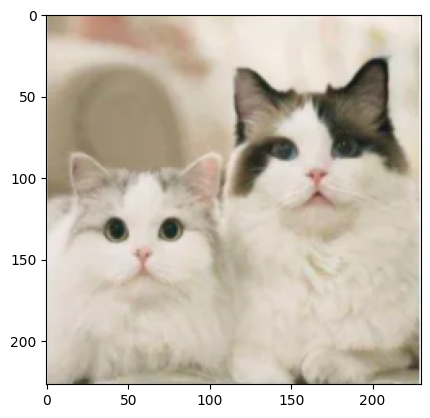

In [191]:
# 数据处理，先缩放尺寸到(224,224)，再变换数据类型为tensor,最后normalize
normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

img = Image.open('src/cat.png')
plt.figure()
plt.imshow(img)

input = preprocess(img)
input = input.unsqueeze(0)
output = net(input)

正向传播，得到输入图像的预测类别：

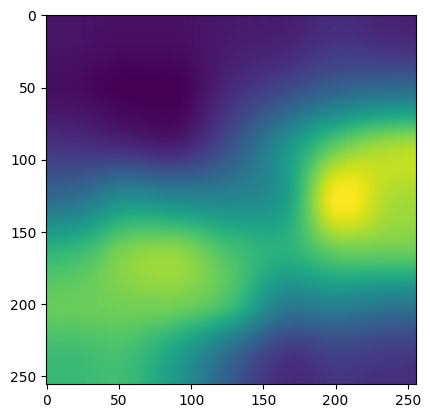

In [193]:
### 计算每个类别的预测类概率
h_x = F.softmax(output, dim=1).data.squeeze()
probs, idx = h_x.sort(0, True)
### 计算CAM
CAM = returnCAM(features_blobs[0], weight_softmax, idx[0])
### 可视化
heatmap = plt.imshow(CAM)

参考文献：

\[1\] Zhou, Bolei, et al. "Learning deep features for discriminative localization." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.

\[2\] He, Kaiming, et al. "Deep residual learning for image recognition." Proceedings of the IEEE conference on computer vision and pattern recognition. 2016.